In [1]:
from transformers import BertForSequenceClassification, BertTokenizer, TrainingArguments, Trainer
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix


c:\Users\luann\anaconda3\envs\TorchEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=3)
state_dict=torch.load('bert_rumor_detection.pth')

state_dict = {k: v for k, v in state_dict.items() if 'classifier' not in k}

model.load_state_dict(state_dict,strict=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=[])

In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    task_type="SEQ_CLS", 
    r=16,  # rank
    lora_alpha=32, 
    lora_dropout=0.1, 
)

model = get_peft_model(model, lora_config)

#Unfreeze top 2 encoder layers of BERT
for name, param in model.base_model.model.bert.encoder.layer[-4:].named_parameters():
    param.requires_grad = True



base_model.model.base_model.model.classifier.original_module.weight False
base_model.model.base_model.model.classifier.original_module.bias False
base_model.model.base_model.model.classifier.modules_to_save.default.weight True
base_model.model.base_model.model.classifier.modules_to_save.default.bias True


c:\Users\luann\anaconda3\envs\TorchEnv\lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
c:\Users\luann\anaconda3\envs\TorchEnv\lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [25]:
print(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(model)}")

Trainable parameters: 14472963


In [6]:
from torch.utils.data import Dataset
import json

class MyRumorDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts=texts
        self.labels=labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = int(self.labels.iloc[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt",
            return_attention_mask=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [27]:
import pandas as pd
import json

with open('matched_data.jsonl', 'r', encoding='utf-8') as f:
    data = []
    for line in f:
        line = line.strip()  # Remove any leading/trailing spaces
        if line:  # Ensure it's not an empty line
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error parsing line: {line}")
                print(f"Error message: {e}")

df = pd.DataFrame(data)

# Split 'policies' into two columns: 'policy_text' and 'entities'
df['entities_in_policy'] = df['policies'].apply(lambda x: x[0]['entities'] if isinstance(x, list) and len(x) > 0 else None)
df['policies'] = df['policies'].apply(lambda x: x[0]['policy_text'] if isinstance(x, list) and len(x) > 0 else None)
df['policies'] = df['policies'].fillna('') 
df['input'] = df['text'] + '[SEP]' + df['policies']
columns = [col for col in df.columns if col != 'label']  # All columns except 'label'
columns.append('label')  # Append 'label' as the last column
df = df[columns]

df.head(10)


,id,text,entities,policies,entities_in_policy,input,label
0,P001,The Texas Heartbeat Act prohibits abortions af...,"[[Texas Heartbeat Act, LAW], [six weeks, TIME]]",A physician may not knowingly perform or induc...,"[[fetal heartbeat, MEDICAL]]",The Texas Heartbeat Act prohibits abortions af...,truth
1,P002,SB8 allows anyone to sue anyone who 'aids or a...,"[[SB8, LAW], [$10,000, MONEY]]",If a claimant prevails in an action brought un...,"[[$10,000, MONEY]]",SB8 allows anyone to sue anyone who 'aids or a...,truth
2,P003,"Under the Texas Heartbeat Act, the state's att...","[[Texas Heartbeat Act, LAW], [attorney general...",Notwithstanding Section 171.005 or any other l...,"[[private civil actions, LEGAL]]","Under the Texas Heartbeat Act, the state's att...",truth
3,P004,The law defines pregnancy as beginning at fert...,"[[fertilization, MEDICAL], [implantation, MEDI...",'Pregnancy' means the human female reproductiv...,"[[fertilization, MEDICAL]]",The law defines pregnancy as beginning at fert...,truth
4,P005,Texas will imprison doctors who perform aborti...,"[[doctors, PROFESSION], [imprison, LEGAL]]","Any person, other than an officer or employee ...","[[civil action, LEGAL]]",Texas will imprison doctors who perform aborti...,rumor
5,P006,Physicians are required to document if an abor...,"[[medical emergency, MEDICAL], [document, ACTI...",If an abortion is performed or induced on a pr...,"[[medical emergency, MEDICAL], [written docume...",Physicians are required to document if an abor...,truth
6,P007,Women who have abortions can be sued and fined...,"[[women, DEMOGRAPHIC], [sued, LEGAL], [fined, ...",This subchapter may not be construed to: (1) a...,"[[woman, DEMOGRAPHIC], [cause of action, LEGAL]]",Women who have abortions can be sued and fined...,rumor
7,P008,Texas SB8 allows a rapist to sue a doctor who ...,"[[rapist, CRIMINAL], [victim, PERSON]]","Notwithstanding any other law, a civil action ...","[[rape, CRIMINAL], [sexual assault, CRIMINAL],...",Texas SB8 allows a rapist to sue a doctor who ...,rumor
8,P009,A provision within SB8 states that ignorance o...,"[[ignorance of the law, LEGAL], [defense, LEGAL]]","Notwithstanding any other law, the following a...","[[ignorance, CONCEPT], [mistake of law, LEGAL]]",A provision within SB8 states that ignorance o...,truth
9,P010,The Texas Heartbeat Act prohibits enforcement ...,"[[state officials, PERSON], [federal courts, O...",Notwithstanding Section 171.005 or any other l...,"[[private civil actions, LEGAL]]",The Texas Heartbeat Act prohibits enforcement ...,unverified


In [8]:
df['label'] = df['label'].map({'truth': 0, 'rumor': 1, 'unverified':2})

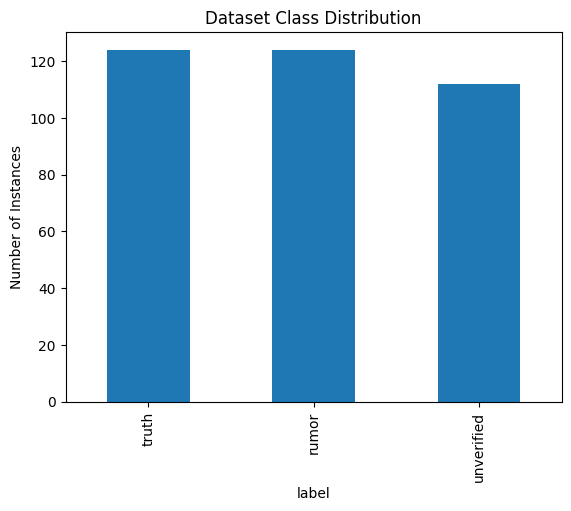

In [28]:
# Plotting a bar chart for visual analysis
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar')
plt.title("Dataset Class Distribution")
plt.ylabel("Number of Instances")
plt.show()


In [29]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    df, 
    test_size=0.3, 
    stratify=df['label'], 
    random_state=42
)

In [30]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [12]:
# Create datasets
# train_text=train_df['text'].tolist()
# train_label=train_df['label'].tolist()

train_dataset = MyRumorDataset(
    texts=train_df['input'],
    labels=train_df['label'],
    tokenizer=tokenizer,
   
)


# val_text=val_df['text'].tolist()
# val_label=val_df['label'].tolist()

val_dataset = MyRumorDataset(
    texts=val_df['input'],
    labels=val_df['label'],
    tokenizer=tokenizer,

)


In [13]:
from torch.utils.data import DataLoader
train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32)

In [14]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup

In [15]:
optimizer = AdamW(model.parameters(), lr=1e-5,weight_decay=0.01)
loss_fn = CrossEntropyLoss()

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 13

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=200,
    num_training_steps=len(train_loader) * num_epochs  # Number of steps per epoch * number of epochs
)

In [16]:
from sklearn.metrics import f1_score

In [17]:
import numpy as np
import torch
import torch.nn as nn

# Suppose train_dataset.labels is a pandas Series or list of labels
labels = np.array(train_dataset.labels)

# Get unique classes and their counts
unique_classes, class_counts = np.unique(labels, return_counts=True)

# Compute weights as the inverse of counts (or use other heuristics)
weights = 1.0 / class_counts
print("Class weights:", weights)

# Convert weights to a torch tensor and move to device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Class weights: [0.01149425 0.01149425 0.01282051]


In [18]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits=outputs.logits
        loss=loss_fn(logits,labels)
        
        loss.backward()

        optimizer.step()
        scheduler.step()  # Update learning rate scheduler

        # Keep track of the running loss
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}")

    # Evaluate on the validation set
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            # Calculate accuracy
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).sum().item() / len(all_labels)
    val_f1 = f1_score(all_labels, all_preds, average='macro')  # macro for multi-class balance

    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

Epoch 1/13, Loss: 1.1833
Validation Loss: 1.1718, Accuracy: 0.1481, F1 Score: 0.1482
Epoch 2/13, Loss: 1.1622
Validation Loss: 1.1414, Accuracy: 0.1944, F1 Score: 0.1934
Epoch 3/13, Loss: 1.1047
Validation Loss: 1.0964, Accuracy: 0.2778, F1 Score: 0.2786
Epoch 4/13, Loss: 1.0816
Validation Loss: 1.0402, Accuracy: 0.4815, F1 Score: 0.4586
Epoch 5/13, Loss: 1.0214
Validation Loss: 1.0030, Accuracy: 0.5741, F1 Score: 0.5324
Epoch 6/13, Loss: 0.9687
Validation Loss: 0.9496, Accuracy: 0.6389, F1 Score: 0.6139
Epoch 7/13, Loss: 0.9104
Validation Loss: 0.8961, Accuracy: 0.7037, F1 Score: 0.7000
Epoch 8/13, Loss: 0.8457
Validation Loss: 0.8317, Accuracy: 0.7315, F1 Score: 0.7291
Epoch 9/13, Loss: 0.7879
Validation Loss: 0.7932, Accuracy: 0.7315, F1 Score: 0.7233
Epoch 10/13, Loss: 0.7399
Validation Loss: 0.7553, Accuracy: 0.7315, F1 Score: 0.7233
Epoch 11/13, Loss: 0.6829
Validation Loss: 0.7280, Accuracy: 0.7407, F1 Score: 0.7390
Epoch 12/13, Loss: 0.6531
Validation Loss: 0.6982, Accuracy: 0.

In [19]:
# #save the weight/config/tokenizer
# output_dir = "./saved_lora_model"
# torch.save(model.state_dict(), f"{output_dir}/pytorch_model.bin")
# model.config.save_pretrained(output_dir)
# lora_config.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

In [20]:
# #load the model for testing

# from transformers import BertTokenizer, BertForSequenceClassification
# from peft import PeftModel, PeftConfig
# import torch

# output_dir = "./saved_lora_model"
# tokenizer = BertTokenizer.from_pretrained(output_dir)
# peft_config = PeftConfig.from_pretrained(output_dir)
# # Load the base model
# base_model = BertForSequenceClassification.from_pretrained(lora_config.base_model_name_or_path,num_labels=3)

# # Apply LoRA to base model
# model = get_peft_model(base_model, lora_config)
# model.load_state_dict(torch.load(f"{output_dir}/pytorch_model.bin"))